## arrcat

Makes the HELIO4CAST ARRIVAL catalog for solar storms (CMEs) observed with the STEREO heliospheric imager instruments.

Authors: Christian Möstl, Eva Weiler, Austrian Space Weather Office, GeoSphere Austria <br />
Loads the HIGeoCat catalog produced by D. Barnes, J. A. Davies, R. A. Harrison, RAL Space, UK.

This code is part of https://github.com/cmoestl/heliocats

**current version is ARRCAT 2.0, released 2020 May 13, updated 2023 October 18**

Install a conda environment to run this code, see readme at https://github.com/cmoestl/heliocats <br />
The environment defined in "env_helio4.yml" is used, the file can be found in the folder "/envs".

**This catalog is hosted at:**

https://helioforecast.space/arrcat <br/>
https://doi.org/10.6084/m9.figshare.12271292

Please cite this catalog with the doi in the figshare repository.

**Issues:**

- need to add plots for each event
- may add Ulysses again with the position in the ulysses data file
- same for messenger
- the kernel for Solar Orbiter needs to be manually updated, see cats.py astrospice.SPKKernel in make_arrival_catalog ...
- with next arrcat update, check if Solar Orbiter positions are consistent with general positions file


In [1]:
last_update='2023-October-18'
debug_mode=1


import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
from datetime import timedelta
import seaborn as sns
import datetime
import astropy
import astropy.constants as const
import time
from sunpy.time import parse_time
import pickle
import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import h5py
import pickle

#from heliocats import plot as hp
#from heliocats import data as hd
from heliocats import cats as hc
#from heliocats import stats as hs


print(' ')
print('------ PATHS ')

########### make directories first time if not there

resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

catdir='arrcat'
if os.path.isdir(catdir) == False: os.mkdir(catdir)

icplotsdir='arrcat/plots_arrcat/' 
if os.path.isdir(icplotsdir) == False: os.mkdir(icplotsdir) 


##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    matplotlib.use('Agg') 
    from config_server import kernels_path
    
    
#mac - make sure the dpi is always set similar to plt.savefig
if sys.platform =='darwin':  
    print('system is mac')
    #for testing
    %matplotlib inline     
    from config_local import kernels_path
    #matplotlib.use('Agg') 

print(kernels_path)

#Convert this notebook to a script with jupyter nbconvert --to script icmecat.ipynb
os.system('jupyter nbconvert --to script arrcat.ipynb') 

#test execution times
t0all = time.time()

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")


/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 
------ PATHS 
system is mac
/Users/chris/python/data/kernels/


[NbConvertApp] Converting notebook arrcat.ipynb to script
[NbConvertApp] Writing 23773 bytes to arrcat.py


## 1 Make arrival catalog 

In [3]:
t0=time.time()

if debug_mode > 0:
    from heliocats import cats as hc
    importlib.reload(hc) #reload again while debugging 

#https://www.helcats-fp7.eu/
#LOAD HELCATS HIGeoCAT
url_higeocat='https://www.helcats-fp7.eu/catalogues/data/HCME_WP3_V06.vot'

try: urllib.request.urlretrieve(url_higeocat,'data/HCME_WP3_V06.vot')
except urllib.error.URLError as e:
    print('higeocat not loaded')

higeocat=hc.load_higeocat_vot('data/HCME_WP3_V06.vot')
higeocat_time=parse_time(higeocat['Date']).datetime    
higeocat_t0=parse_time(higeocat['SSE Launch']).datetime   #backprojected launch time

#define empty pandas dataframe for arrival catalog with column names

column_list=['id', 'sc','target_name','sse_launch_time','target_arrival_time','target_arrival_time_err',\
                                 'target_distance','target_heeq_lon','target_heeq_lat',\
                                 'target_delta','sse_heeq_lon','sse_heeq_lat',\
                                 'sse_speed','sse_speed_err','target_speed','target_speed_err',\
                                 'pa_fit','pa_n','pa_s','pa_center']
             
#pandas dataframe for current version with iteration in calculating arrival time
ac = pd.DataFrame([], columns = column_list)

ac=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, 'PSP',column_list,kernels_path)
ac=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, 'SolarOrbiter',column_list,kernels_path)
ac=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, 'BepiColombo',column_list,kernels_path)  
ac=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, 'STEREO-A',column_list,kernels_path)

ac=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, 'STEREO-B',column_list,kernels_path)
#need to get Ulysses position
#ac=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, 'Ulysses',column_list)
#add messenger similarly
#ac=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, 'Messenger',column_list)


ac=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, 'Mercury',column_list,kernels_path)
ac=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, 'Venus',column_list,kernels_path)
ac=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, 'Earth_L1',column_list,kernels_path)
ac=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, 'Mars',column_list,kernels_path)


ac = ac.sort_values(by='target_arrival_time',ascending=False)
ac = ac.reset_index(drop=True)

t1=time.time()
print('making the arrcat took ', np.round(t1-t0,2), 'seconds')


ac

Files Downloaded: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01file/s]


SSEF30 events:  76
PSP  SSEF30 arrival catalog finished.

SSEF30 events:  53
SolarOrbiter  SSEF30 arrival catalog finished.



Files Downloaded: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34file/s]


SSEF30 events:  87
BepiColombo  SSEF30 arrival catalog finished.



Files Downloaded: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45file/s]


SSEF30 events:  214
STEREO-A  SSEF30 arrival catalog finished.



Files Downloaded: 100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.02file/s]


SSEF30 events:  139
STEREO-B  SSEF30 arrival catalog finished.

SSEF30 events:  265
Mercury  SSEF30 arrival catalog finished.

SSEF30 events:  305
Venus  SSEF30 arrival catalog finished.

SSEF30 events:  666
Earth_L1  SSEF30 arrival catalog finished.

SSEF30 events:  307
Mars  SSEF30 arrival catalog finished.

making the arrcat took  205.94 seconds


,id,sc,target_name,sse_launch_time,target_arrival_time,target_arrival_time_err,target_distance,target_heeq_lon,target_heeq_lat,target_delta,sse_heeq_lon,sse_heeq_lat,sse_speed,sse_speed_err,target_speed,target_speed_err,pa_fit,pa_n,pa_s,pa_center
0,HCME_A__20230921_01,A,Mars,2023-09-21T12:17Z,2023-09-26T21:56Z,12.2,1.599,-153.62,-4.60,-11.6,-142,-5,535,50,513,48,90,20,155,87.5
1,HCME_A__20230920_01,A,Mars,2023-09-20T03:08Z,2023-09-25T10:29Z,17.9,1.601,-152.87,-4.64,-6.9,-146,-6,530,73,522,72,90,20,155,87.5
2,HCME_A__20230919_01,A,STEREO-A,2023-09-19T11:23Z,2023-09-24T01:02Z,2.4,0.961,3.61,6.95,19.6,-16,-6,416,9,364,8,125,70,155,112.5
3,HCME_A__20230919_01,A,Earth_L1,2023-09-19T11:23Z,2023-09-23T23:22Z,2.3,0.993,-0.00,7.02,16.0,-16,-6,416,9,382,8,125,70,155,112.5
4,HCME_A__20230922_01,A,BepiColombo,2023-09-21T22:49Z,2023-09-22T22:14Z,0.3,0.453,-36.87,0.81,-3.9,-33,31,807,9,803,9,50,20,155,87.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,HCME_A__20070518_01,A,Venus,2007-05-17T20:34Z,2007-05-20T09:17Z,0.3,0.720,-57.25,-3.69,20.7,-78,-20,574,3,493,3,110,95,115,105.0
2108,HCME_A__20070518_01,A,Mercury,2007-05-17T20:34Z,2007-05-19T01:13Z,0.1,0.337,-99.24,0.56,-21.2,-78,-20,574,3,489,3,110,95,115,105.0
2109,HCME_A__20070516_01,A,Venus,2007-05-15T16:24Z,2007-05-18T23:10Z,0.2,0.720,-58.20,-3.74,-5.2,-53,16,383,1,380,1,70,30,120,75.0
2110,HCME_A__20070509_01,A,Mercury,2007-05-09T06:13Z,2007-05-10T07:53Z,2.8,0.308,-142.21,2.96,-0.2,-142,2,499,54,499,54,90,50,125,87.5


## 2 save ARRCAT


#### save header

In [4]:
first_date=ac['target_arrival_time'][len(ac)-1]
last_date=ac['target_arrival_time'][0]
print(last_date[0:7])
print(first_date[0:7])

2023-09
2007-04


In [5]:
#save header and parameters as text file and prepare for html website
header='ARRIVAL CATALOGUE 2.0 \n\n\
In this ARRival CATalog (ARRCAT), the arrivals of solar coronal mass ejections that were \n\
tracked with the STEREO heliospheric imagers are calculated.\n\
ARRCAT lists modeled arrivals of CMEs at various spacecraft and planets, \n\
based on the HIGeoCAT catalog of CMEs established at RAL Space, UK (D. Barnes, J. A. Davies, R. A. Harrison). \n\n\
This is version 2.0, released 2020-May-13, updated '+last_update+'. https://doi.org/10.6084/m9.figshare.12271292\n\n\
It is based on this HIGeoCAT version: '+url_higeocat+' using the SSEF30 model.\n\n\
The catalog is available as python pandas dataframe (pickle), \n\
python numpy arrays (pickle, as recarray and structured array), \n\
npy (numpy, no pickle), json, csv, xlsx, txt, hdf5, html at \n\
https://helioforecast.space/arrcat \n\n\
Number of events in ARRCAT: '+str(len(ac))+' \n\
Targets: Earth_L1, STEREO-A, STEREO-B, Solar Orbiter, Parker Solar Probe (PSP), BepiColombo, Venus, Mercury, Mars.\n\
The catalog covers the timerange '+first_date[0:7]+' to '+last_date[0:7]+' \n\n\
Authors: Christian Moestl (1), Eva weiler (1), D. Barnes (2), R. A. Harrison (2), J. A. Davies (2).\n\
(1) Austrian Space Weather Office, GeoSphere Austria, Graz, Austria, (2) RAL Space, UK.\n\n\
Rules: If results are produced with this catalog for peer-reviewed scientific publications,\n\
please contact chris.moestl@outlook.com for co-authorships.\n\n\
We acknowledge the use of the astrospice and spiceypy python packages.\n\n\
Parameters \n\n\
    0: id: From HIGeoCAT, the unique identifier for the observed CME.\n\
    1: sc: From HIGeoCAT, the HI observing STEREO spacecraft, (A=Ahead or B=Behind)\n\
    2: target_name: Name of in situ target.\n\
    3: sse_launch_time: From HIGeoCAT, launch time of the CME at Sun center, unit: UTC.\n\
    4: target_arrival_time: CME arrival time at target location calculated with the SSEF30 model, corrected for SSE shape (Moestl and Davies, 2013). unit: UTC.\n\
    5: target_arrival_time_err: Error of CME arrival time at target location from SSEF30 model, solely based on error in parameter sse_speed_err. unit: hours.\n\
    6: target_distance: Target distance from Sun, at model CME arrival time. unit: AU.\n\
    7: target_heeq_lon: Target longitude in HEEQ, at model CME arrival time. unit: degree.\n\
    8: target_heeq_lat: Target latitude in HEEQ, at model CME arrival time. unit: degree.\n\
    9: target_delta: Difference in HEEQ longitude between central CME direction and target location at model CME arrival time, \n\
       positive values: spacecraft is west of CME apex. unit: degree.\n\
    10: sse_heeq_lon: From HIGeoCAT, the HEEQ longitude of the CME apex propagation direction, unit: degree.\n\
    11: sse_heeq_lat: From HIGeoCAT, the HEEQ latitude of the CME apex propagation direction, unit: degree.\n\
    12: sse_speed: From HIGeoCAT, speed of the CME apex, unit: km/s.\n\
    13: sse_speed_err: From HIGeoCAT, error in the speed of the CME apex, unit: km/s.\n\
    14: target_speed: CME arrival speed at target location, corrected for SSE shape (Moestl and Davies, 2013). unit: km/s.\n\
    15: target_speed_err: Error in CME arrival speed at target location, corrected for SSE shape (Moestl and Davies, 2013). unit: km/s.\n\
    16: pa_fit: From HIGeoCAT, PA along which time-elongation profile is extracted, unit: degree.\n\
    17: pa_n: From HIGeoCAT, northern position angle of CME, unit: degree.\n\
    18: pa_s: From HIGeoCAT, southernmost position angle of CME, unit: degree.\n\
    19: pa_center: average of pa_n and pa_s, unit: degree.\n\n\
Comments\n\n\
    - Single-Spacecraft fitting of time-elongation tracks observed with heliospheric imagers with the SSEF30 model \n\
      is described in Davies et al. (2012) and Möstl et al. (2014).\n\
    - We have modified the calculation of CME arrival time here by a new iterative method compared to Moestl et al. (2014, 2017). \n\
      In the first iteration, the sse_launch_time is used to calculate the target HEEQ position. \n\
      In subsequent three iterations, we use the arrival time from the previous iteration (instead of sse_launch time) \n\
      to calculate the target HEEQ position. \n\
      In this way we avoid an error of a few degrees in the arrival target location (see also Moestl et al. 2017). \n\
    - The analytical formulas for calculating the speeds and arrival times of the CMEs modeled with SSEF30, \n\
      corrected for the SSEF30 circular shape, can be found in Moestl & Davies (2013). \n\
    - The position for the Sun-Earth L1 point, with the target_name "Earth_L1", \n\
      is set as the position of Earth with the radial distance reduced by 0.01 AU. \n\n\n\
References \n\n\
Davies et al. (2012)   https://doi.org/10.1088/0004-637X/750/1/23 (open access)  \n\
Moestl & Davies (2013) https://doi.org/10.1007/s11207-012-9978-8 arxiv: https://arxiv.org/abs/1202.1299\n\
Moestl et al. (2014)   https://doi.org/10.1088/0004-637X/787/2/119 (open access) \n\
Moestl et al. (2017)   https://doi.org/10.1002/2017SW001614 (open access)\n'

print(header)

#make header file
file='arrcat/HELCATS_ARRCAT_v20_header.txt'
with open(file, "w") as text_file:
    text_file.write(header)
print()    
print('header saved as '+file)
print()    

#Convert to html regarding line breaks, paragraph beginning and spaces
header_spaces=header.replace(" ", "&nbsp;")
header_html= "<p>" +header_spaces.replace('\n', '<br>')+ "</p>" 
print('header converted to HTML')
print()    
print()    

print('-----------------------')
print('ARRCAT sorted by time gives:')
np.sort(ac.target_arrival_time)

ARRIVAL CATALOGUE 2.0 

In this ARRival CATalog (ARRCAT), the arrivals of solar coronal mass ejections that were 
tracked with the STEREO heliospheric imagers are calculated.
ARRCAT lists modeled arrivals of CMEs at various spacecraft and planets, 
based on the HIGeoCAT catalog of CMEs established at RAL Space, UK (D. Barnes, J. A. Davies, R. A. Harrison). 

This is version 2.0, released 2020-May-13, updated 2023-October-18. https://doi.org/10.6084/m9.figshare.12271292

It is based on this HIGeoCAT version: https://www.helcats-fp7.eu/catalogues/data/HCME_WP3_V06.vot using the SSEF30 model.

The catalog is available as python pandas dataframe (pickle), 
python numpy arrays (pickle, as recarray and structured array), 
npy (numpy, no pickle), json, csv, xlsx, txt, hdf5, html at 
https://helioforecast.space/arrcat 

Number of events in ARRCAT: 2112 
Targets: Earth_L1, STEREO-A, STEREO-B, Solar Orbiter, Parker Solar Probe (PSP), BepiColombo, Venus, Mercury, Mars.
The catalog covers the time

array(['2007-04-22T23:34Z', '2007-05-10T07:53Z', '2007-05-18T23:10Z', ...,
       '2023-09-24T01:02Z', '2023-09-25T10:29Z', '2023-09-26T21:56Z'],
      dtype=object)

#### save into different formats

In [6]:
########## python formats

# save ARRCAT as pandas dataframe with times as datetime objects as pickle
file='arrcat/HELCATS_ARRCAT_v20_pandas.p'
pickle.dump([ac,header], open(file, 'wb'))
print('ARRCAT saved as '+file)

# save ARRCAT as numpy array with times as matplotlib datetime as pickle
ac_num=copy.deepcopy(ac) 
ac_num.sse_launch_time=parse_time(ac_num.sse_launch_time).plot_date
ac_num.target_arrival_time=parse_time(ac_num.target_arrival_time).plot_date
#convert to recarray
ac_num_rec=ac_num.to_records()
#create structured array 
dtype1=[('index','i8'),('id', '<U30'),('sc', '<U20'),('target_name', '<U20')] +[(i, '<f8') for i in ac.keys()[3:len(ac.keys())]]
ac_num_struct=np.array(ac_num_rec,dtype=dtype1)

file='arrcat/HELCATS_ARRCAT_v20_numpy.p'
pickle.dump([ac_num,ac_num_struct,header], open(file, 'wb'))
print('ARRCAT saved as '+file)




################ save to different formats

#copy pandas dataframe first to change time format consistent with HELCATS
ac_copy=copy.deepcopy(ac)  
#change time format and add Z
ac_copy.sse_launch_time=parse_time(ac.sse_launch_time).isot
ac_copy.target_arrival_time=parse_time(ac.target_arrival_time).isot

for i in np.arange(len(ac)):

    dum=ac_copy.sse_launch_time[i] 
    ac_copy.at[i,'sse_launch_time']=dum[0:16]+'Z'
     
    dum=ac_copy.target_arrival_time[i] 
    ac_copy.at[i,'target_arrival_time']=dum[0:16]+'Z'


#save as Excel
file='arrcat/HELCATS_ARRCAT_v20.xlsx'
ac_copy.to_excel(file,sheet_name='ARRCATv2.0')
print('ARRCAT saved as '+file)

#save as json
file='arrcat/HELCATS_ARRCAT_v20.json'
ac_copy.to_json(file)
print('ARRCAT saved as '+file)

#save as csv
file='arrcat/HELCATS_ARRCAT_v20.csv'
ac_copy.to_csv(file)
print('ARRCAT saved as '+file)

#save as txt
file='arrcat/HELCATS_ARRCAT_v20.txt'
np.savetxt(file, ac_copy.values.astype(str), fmt='%s' )
print('ARRCAT saved as '+file)






#########################

#########save into hdf5 format , use S for strings http://docs.h5py.org/en/stable/strings.html#what-about-numpy-s-u-type
dtype2=[('index','i8'),('id', 'S30'),('sc', 'S20'),('target_name', 'S20')] +[(i, '<f8') for i in ac.keys()[3:len(ac.keys())]]
ach5=np.array(ac_num_rec,dtype=dtype2)
file='arrcat/HELCATS_ARRCAT_v20.h5'
f=h5py.File(file,mode='w')
f["arrcat"]= ach5

#add attributes
#************************
#***********************

print('ARRCAT saved as '+file)
f.close()

#reading h5py files http://docs.h5py.org/en/latest/quick.html
#fr = h5py.File('icmecat/HELCATS_ICMECAT_v20.h5', 'r')
#list(fr.keys())
#ich5=fr['icmecat']
#ich5['mo_bstd']
#ich5.dtype
#fr.close()
##################


#save as .npy without pickle
file='arrcat/HELCATS_ARRCAT_v20_numpy.npy'
np.save(file,ach5, allow_pickle=False)
print('ARRCAT saved as '+file)

#for loading do:
#icnpy=np.load(file)
#decode strings:
#icnpy['icmecat_id'][0].decode()



############ other formats

#copy pandas dataframe first to change time format 
ac_copy2=copy.deepcopy(ac)  
ac_copy2.sse_launch_time=parse_time(ac.sse_launch_time).iso
ac_copy2.target_arrival_time=parse_time(ac.target_arrival_time).iso

#change time format
for i in np.arange(len(ac)):

    dum=ac_copy2.sse_launch_time[i] 
    ac_copy2.at[i,'sse_launch_time']=dum[0:16]
     
    dum=ac_copy2.target_arrival_time[i] 
    ac_copy2.at[i,'target_arrival_time']=dum[0:16]


#save as json for webpage with different time format
file='arrcat/HELCATS_ARRCAT_v20_iso.json'
ac_copy2.to_json(file)
print('ARRCAT saved as '+file)

#save as html no header
file='arrcat/HELCATS_ARRCAT_v20_simple.html'
ac_copy.to_html(file)
print('ARRCAT saved as '+file)

############ save as html file with header
#save as html
file='arrcat/HELCATS_ARRCAT_v20.html'
#ic.to_html(file,justify='center')

#ichtml='{% extends "_base.html" %} \n \n {% block content %} \n \n \n '
achtml = header_html
achtml += ac_copy.to_html()
#ichtml +='\n \n {% endblock %}'


with open(file,'w') as f:
    f.write(achtml)
    f.close()
    
print('ARRCAT saved as '+file)    

ARRCAT saved as arrcat/HELCATS_ARRCAT_v20_pandas.p
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20_numpy.p
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20.xlsx
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20.json
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20.csv
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20.txt
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20.h5
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20_numpy.npy
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20_iso.json
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20_simple.html
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20.html


## 3 load ARRCAT examples

In [7]:
#load arrcat as pandas dataframe
file='arrcat/HELCATS_ARRCAT_v20_pandas.p'
[ac_pandas,h]=pickle.load( open(file, 'rb'))   

#load arrcat as numpy array
file='arrcat/HELCATS_ARRCAT_v20_numpy.p'
[ac_rec,ac_struct,h]=pickle.load( open(file, 'rb'))   


#load arrcat from hdf5
file5='arrcat/HELCATS_ARRCAT_v20.h5'
f = h5py.File(file5, 'r')
list(f.keys())
ac5 = f['arrcat']
ac5['sse_launch_time']

array([19621.51180556, 19620.13055556, 19619.47430556, ...,
       13648.68333333, 13642.25902778, 13622.28472222])

In [8]:
ac_pandas
ac_pandas.keys()

Index(['id', 'sc', 'target_name', 'sse_launch_time', 'target_arrival_time',
       'target_arrival_time_err', 'target_distance', 'target_heeq_lon',
       'target_heeq_lat', 'target_delta', 'sse_heeq_lon', 'sse_heeq_lat',
       'sse_speed', 'sse_speed_err', 'target_speed', 'target_speed_err',
       'pa_fit', 'pa_n', 'pa_s', 'pa_center'],
      dtype='object')

In [9]:
ac

,id,sc,target_name,sse_launch_time,target_arrival_time,target_arrival_time_err,target_distance,target_heeq_lon,target_heeq_lat,target_delta,sse_heeq_lon,sse_heeq_lat,sse_speed,sse_speed_err,target_speed,target_speed_err,pa_fit,pa_n,pa_s,pa_center
0,HCME_A__20230921_01,A,Mars,2023-09-21T12:17Z,2023-09-26T21:56Z,12.2,1.599,-153.62,-4.60,-11.6,-142,-5,535,50,513,48,90,20,155,87.5
1,HCME_A__20230920_01,A,Mars,2023-09-20T03:08Z,2023-09-25T10:29Z,17.9,1.601,-152.87,-4.64,-6.9,-146,-6,530,73,522,72,90,20,155,87.5
2,HCME_A__20230919_01,A,STEREO-A,2023-09-19T11:23Z,2023-09-24T01:02Z,2.4,0.961,3.61,6.95,19.6,-16,-6,416,9,364,8,125,70,155,112.5
3,HCME_A__20230919_01,A,Earth_L1,2023-09-19T11:23Z,2023-09-23T23:22Z,2.3,0.993,-0.00,7.02,16.0,-16,-6,416,9,382,8,125,70,155,112.5
4,HCME_A__20230922_01,A,BepiColombo,2023-09-21T22:49Z,2023-09-22T22:14Z,0.3,0.453,-36.87,0.81,-3.9,-33,31,807,9,803,9,50,20,155,87.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,HCME_A__20070518_01,A,Venus,2007-05-17T20:34Z,2007-05-20T09:17Z,0.3,0.720,-57.25,-3.69,20.7,-78,-20,574,3,493,3,110,95,115,105.0
2108,HCME_A__20070518_01,A,Mercury,2007-05-17T20:34Z,2007-05-19T01:13Z,0.1,0.337,-99.24,0.56,-21.2,-78,-20,574,3,489,3,110,95,115,105.0
2109,HCME_A__20070516_01,A,Venus,2007-05-15T16:24Z,2007-05-18T23:10Z,0.2,0.720,-58.20,-3.74,-5.2,-53,16,383,1,380,1,70,30,120,75.0
2110,HCME_A__20070509_01,A,Mercury,2007-05-09T06:13Z,2007-05-10T07:53Z,2.8,0.308,-142.21,2.96,-0.2,-142,2,499,54,499,54,90,50,125,87.5


In [10]:
ac_rec.id
ac_rec.target_name[5]

'BepiColombo'

In [11]:
ac_struct

array([(   0, 'HCME_A__20230921_01', 'A', 'Mars', 19621.51180556, 19626.91388889, 12.2, 1.599, -153.62, -4.6 , -11.6, -142.,  -5., 535., 50., 513., 48.,  90., 20., 155.,  87.5),
       (   1, 'HCME_A__20230920_01', 'A', 'Mars', 19620.13055556, 19625.43680556, 17.9, 1.601, -152.87, -4.64,  -6.9, -146.,  -6., 530., 73., 522., 72.,  90., 20., 155.,  87.5),
       (   2, 'HCME_A__20230919_01', 'A', 'STEREO-A', 19619.47430556, 19624.04305556,  2.4, 0.961,    3.61,  6.95,  19.6,  -16.,  -6., 416.,  9., 364.,  8., 125., 70., 155., 112.5),
       ...,
       (2109, 'HCME_A__20070516_01', 'A', 'Venus', 13648.68333333, 13651.96527778,  0.2, 0.72 ,  -58.2 , -3.74,  -5.2,  -53.,  16., 383.,  1., 380.,  1.,  70., 30., 120.,  75. ),
       (2110, 'HCME_A__20070509_01', 'A', 'Mercury', 13642.25902778, 13643.32847222,  2.8, 0.308, -142.21,  2.96,  -0.2, -142.,   2., 499., 54., 499., 54.,  90., 50., 125.,  87.5),
       (2111, 'HCME_A__20070419_01', 'A', 'Venus', 13622.28472222, 13625.98194444,  0.5, 0

### plot directions and targets

saved as  arrcat/plots_arrcat/arrcat_targets.png


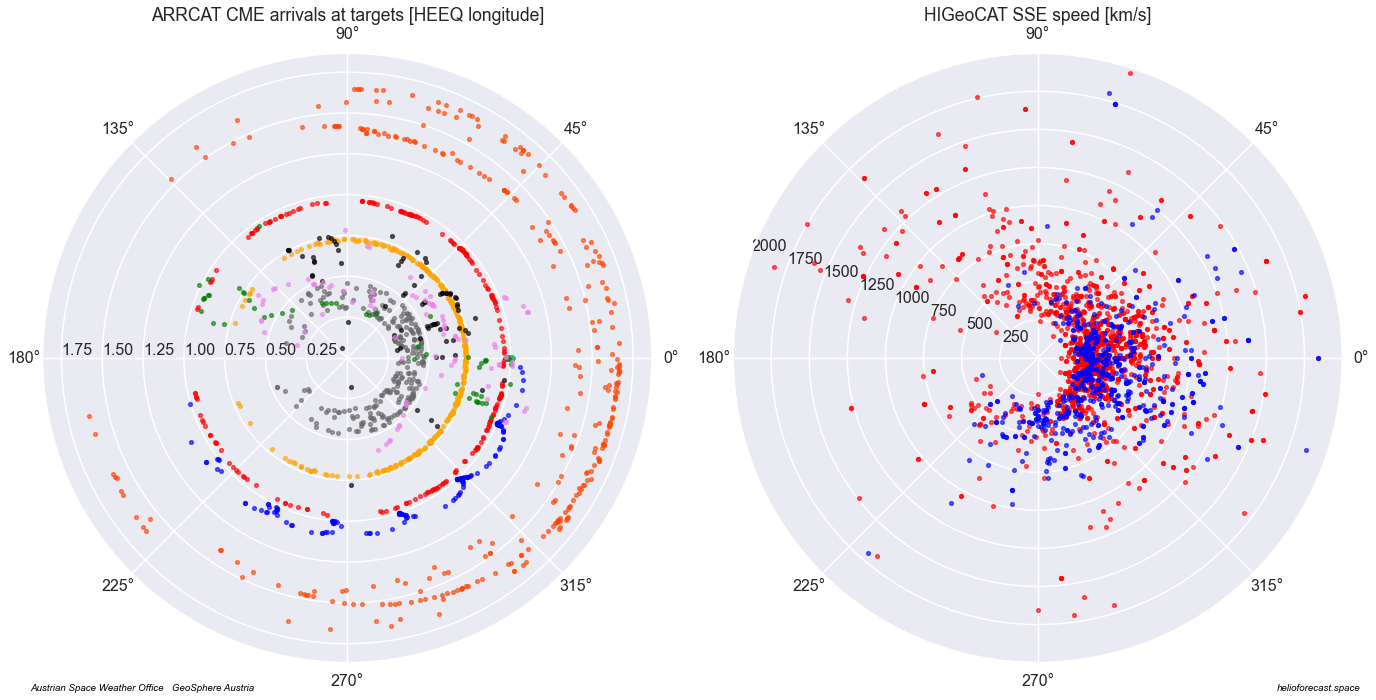

In [12]:
sns.set_context('talk')
sns.set_style('darkgrid')

fig=plt.figure(1, figsize=(20,10), dpi=70) 
ax = plt.subplot(121,projection='polar') 

plt.title('ARRCAT CME arrivals at targets [HEEQ longitude]')

#get indices for each target
merci=np.where(ac.target_name=='Mercury')[0]
venusi=np.where(ac.target_name=='Venus')[0]
earthi=np.where(ac.target_name=='Earth_L1')[0]
marsi=np.where(ac.target_name=='Mars')[0]

stai=np.where(ac.target_name=='STEREO-A')[0]
stbi=np.where(ac.target_name=='STEREO-B')[0]
pspi=np.where(ac.target_name=='PSP')[0]
soloi=np.where(ac.target_name=='SolarOrbiter')[0]
bepii=np.where(ac.target_name=='BepiColombo')[0]
ulyi=np.where(ac.target_name=='Ulysses')[0]

#markersize
ms=15
#alpha
al=0.6

ax.scatter(np.radians(ac.target_heeq_lon[merci]),ac.target_distance[merci],s=ms,c='dimgrey', alpha=al)
ax.scatter(np.radians(ac.target_heeq_lon[venusi]),ac.target_distance[venusi],s=ms,c='orange', alpha=al)
ax.scatter(np.radians(ac.target_heeq_lon[earthi]),ac.target_distance[earthi],s=ms,c='mediumseagreen', alpha=al)
ax.scatter(np.radians(ac.target_heeq_lon[marsi]),ac.target_distance[marsi],s=ms,c='orangered', alpha=al)

ax.scatter(np.radians(ac.target_heeq_lon[stai]),ac.target_distance[stai],s=ms,c='red', alpha=al)
ax.scatter(np.radians(ac.target_heeq_lon[stbi]),ac.target_distance[stbi],s=ms,c='blue', alpha=al)

ax.scatter(np.radians(ac.target_heeq_lon[pspi]),ac.target_distance[pspi],s=ms,c='black', alpha=al)
ax.scatter(np.radians(ac.target_heeq_lon[soloi]),ac.target_distance[soloi],s=ms,c='green', alpha=al)
ax.scatter(np.radians(ac.target_heeq_lon[bepii]),ac.target_distance[bepii],s=ms,c='violet', alpha=al)
ax.scatter(np.radians(ac.target_heeq_lon[ulyi]),ac.target_distance[ulyi],s=ms,c='brown', alpha=al)

plt.ylim([0,np.max(ac.target_distance)+0.2])

#ax.set_theta_zero_location("W")
ax.set_rlabel_position(180)


ax = plt.subplot(122,projection='polar')
plt.title('HIGeoCAT SSE speed [km/s]')
hiai=np.where(ac.sc=='A')[0]
hibi=np.where(ac.sc=='B')[0]

ax.scatter(np.radians(ac.sse_heeq_lon[hiai].astype(float)),ac.sse_speed[hiai],s=ms,c='red', alpha=al)
ax.scatter(np.radians(ac.sse_heeq_lon[hibi].astype(float)),ac.sse_speed[hibi],s=ms,c='blue', alpha=al)

ax.set_rlabel_position(160)
#plt.ylim([0,np.max(ac.sse_speed)+100])
plt.ylim([0,2000])

plt.figtext(0.03,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=10, style='italic')
plt.figtext(0.98,0.01,'helioforecast.space', color='black', ha='right',fontsize=10, style='italic')

plt.tight_layout()

plotfile='arrcat/plots_arrcat/arrcat_targets.png'
plt.savefig(plotfile,dpi=100)
print('saved as ',plotfile)

### plot error distributions

mean sse_speed error 45 +/- 86  km/s
mean target arrival time error from sse_speed error 6 +/- 30 hours
saved as  arrcat/plots_arrcat/arrcat_errors_dist.png


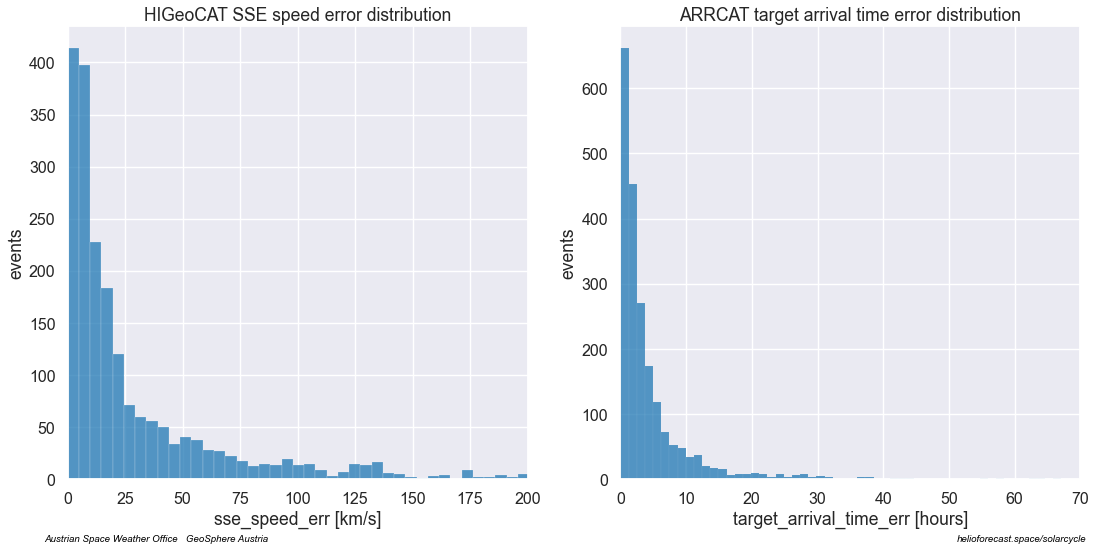

In [13]:
fig=plt.figure(2, figsize=(16,8), dpi=70)

ax = plt.subplot(121) 
sns.histplot(ac.sse_speed_err,bins=200,kde=False)
plt.xlim(0,200)
plt.ylabel('events')
plt.xlabel('sse_speed_err [km/s]')
plt.title('HIGeoCAT SSE speed error distribution')
print('mean sse_speed error',np.mean(ac.sse_speed_err).astype(int),'+/-',np.std(ac.sse_speed_err).astype(int),' km/s' )
ax.grid(True)

ax2 = plt.subplot(122) 
sns.histplot(ac.target_arrival_time_err,bins=800,kde=False)
plt.xlim(0,70)
plt.title('ARRCAT target arrival time error distribution')
plt.ylabel('events')
plt.xlabel('target_arrival_time_err [hours]')
print('mean target arrival time error from sse_speed error',np.mean(ac.target_arrival_time_err).astype(int),'+/-',np.std(ac.target_arrival_time_err).astype(int),'hours' )

ax2.grid(True)
plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=10, style='italic')
plt.figtext(0.98,0.01,'helioforecast.space/solarcycle', color='black', ha='right',fontsize=10, style='italic')


plt.tight_layout()

plotfile='arrcat/plots_arrcat/arrcat_errors_dist.png'
plt.savefig(plotfile,dpi=100)
print('saved as ',plotfile)

## HIGeoCAT CME rates plot






In [14]:


hiai=np.where(higeocat['SC']=='A')[0]
hibi=np.where(higeocat['SC']=='B')[0]

hia_t0=higeocat['SSE Launch'][hiai]
hib_t0=higeocat['SSE Launch'][hibi]

last_year=datetime.datetime.utcnow().year+1
#define dates 
years_jan_1_str=[str(i)+'-01-01' for i in np.arange(2007,last_year+1) ] 
yearly_bin_edges=parse_time(years_jan_1_str).plot_date

print(years_jan_1_str)

months_str=[]
#all previous years
for i in np.arange(2007,last_year-1):
    for k in np.arange(1,13):
        months_str.append(str(i)+'-'+str(k).zfill(2)+'-01' )
        
#current year, use the month before last month in the HIGeoCat
last_month=parse_time(hia_t0).datetime[-1].month-1

for k in np.arange(1,last_month+1):
      months_str.append(str(datetime.datetime.utcnow().year)+'-'+str(k).zfill(2)+'-01' )

        
months_bin_edges=parse_time(months_str).plot_date
#months_bin_edges
#

(hist_hia, binedges) = np.histogram(parse_time(hia_t0).plot_date, yearly_bin_edges)
(hist_hib, binedges) = np.histogram(parse_time(hib_t0).plot_date, yearly_bin_edges)

(hist_hia_monthly, binedges_monthly) = np.histogram(parse_time(hia_t0).plot_date, months_bin_edges)
(hist_hib_monthly, binedges_monthly) = np.histogram(parse_time(hib_t0).plot_date, months_bin_edges)

#set to Nan for HIB after September 2014
hist_hib_monthly[93:]=-1


########### TBD add an estimate for the rest of the year


['2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01']


saved as  arrcat/plots_arrcat/higeocat_rate.png


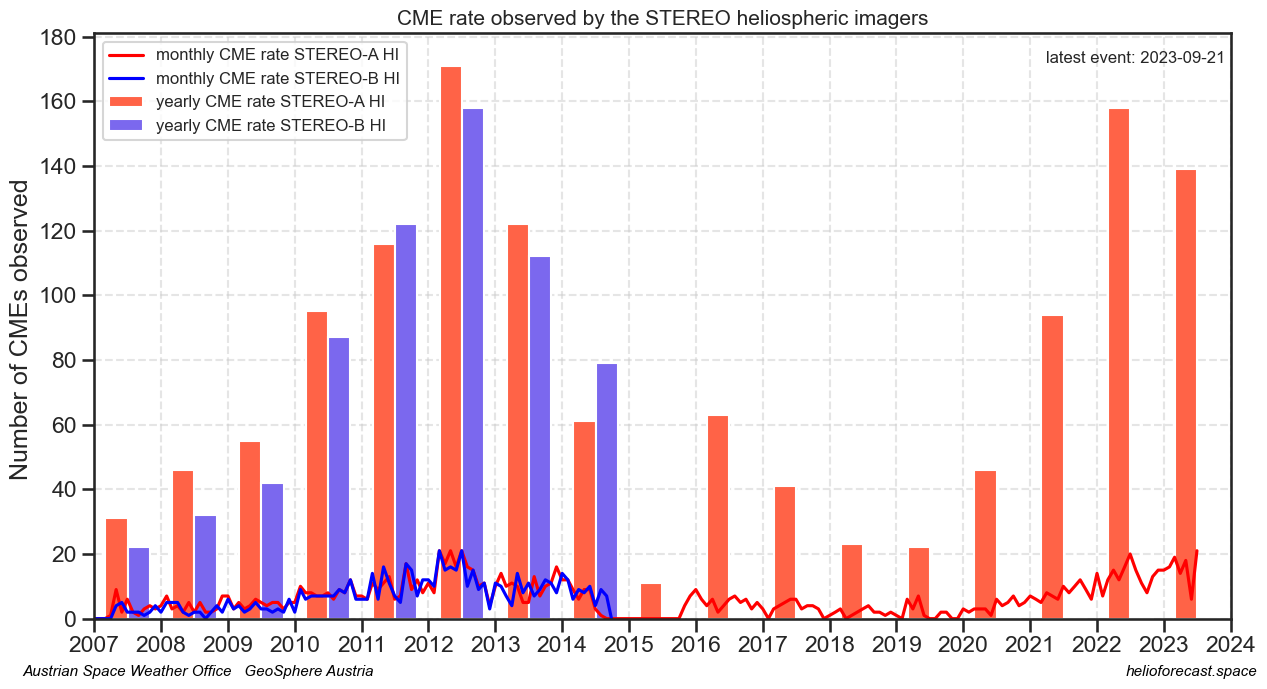

In [15]:

sns.set_context("talk")     
#sns.set_style('darkgrid')
#sns.set_style('whitegrid',{'grid.linestyle': '--'})

sns.set_style("ticks",{'grid.linestyle': '--'})
fsize=15

fig=plt.figure(3,figsize=(13,7),dpi=100)


ax1 = plt.subplot(111) 
ax1.set_title('CME rate observed by the STEREO heliospheric imagers',fontsize=15)

ax1.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(myformat)

binweite=365/3
alp=1.0
ax1.bar(binedges[0:17]+binweite,hist_hia, width=binweite,color='tomato', alpha=alp,label='yearly CME rate STEREO-A HI')
ax1.bar(binedges[0:17]+binweite*2,hist_hib, width=binweite,color='mediumslateblue', alpha=alp,label='yearly CME rate STEREO-B HI')
ax1.plot(binedges_monthly[0:-1], hist_hia_monthly,color='red', label='monthly CME rate STEREO-A HI')
ax1.plot(binedges_monthly[0:-1], hist_hib_monthly,color='blue',label='monthly CME rate STEREO-B HI')


ax1.set_yticks(np.arange(0,300,20))
ax1.set_ylim(0,np.max(hist_hia)+10)
ax1.set_xticks(yearly_bin_edges) 
ax1.set_xlim(yearly_bin_edges[0],yearly_bin_edges[-1])
ax1.legend(loc=2,fontsize=12)
ax1.grid(alpha=0.5)
ax1.set_ylabel('Number of CMEs observed ')

#ax1.text(yearly_bin_edges[-5],150,'latest event: '+str(np.sort(ac.sse_launch_time)[-1][0:10]),fontsize=15,zorder=2,horizontalalignment='center')
plt.annotate('latest event: '+str(np.sort(ac.sse_launch_time)[-1][0:10]),xy=(0.995,0.95),xycoords='axes fraction',fontsize=12,ha='right')

plt.figtext(0.03,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.98,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')

plt.tight_layout()

plotfile='arrcat/plots_arrcat/higeocat_rate.png'
plt.savefig(plotfile,dpi=100)
print('saved as ',plotfile)



In [16]:
print(' ')
print(' ')
print('-------------------------------')
print('The last event launch time in the ARRCAT that we just made is')
print(np.sort(ac.sse_launch_time)[-1])

url='https://helioforecast.space/static/sync/arrcat/HELCATS_ARRCAT_v20.csv' 
arrcat_web=pd.read_csv(url)
print('  ')

print('The last event launch time in the ARRCAT on the web is')
print(np.sort(arrcat_web.sse_launch_time)[-1])



 
 
-------------------------------
The last event launch time in the ARRCAT that we just made is
2023-09-21T22:49Z
  
The last event launch time in the ARRCAT on the web is
2023-09-21T22:49Z


In [17]:
t1all = time.time()
print(' ')
print(' ')
print('---------------------------------- ')
print('arrcat.py takes ', np.round((t1all-t0all),1), 'seconds')
    

 
 
---------------------------------- 
arrcat.py takes  388.1 seconds
